In [1]:
!pip install transformers
!pip install rouge_score
!pip install torch
!pip install -U transformers
!pip install datasets
!pip install peft
!pip install bitsandbytes
!pip install transformers datasets torch
!pip install git+https://github.com/huggingface/peft.git
!pip install adapter-transformers
!pip install rouge_score
!pip install -q -U trl transformers git+https://github.com/huggingface/peft.git
!pip install bitsandbytes
!pip install accelerate
!pip install bitsandbytes
!pip install accelerate
!pip install ter
!pip install bert_score



  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3f7acbcf3e5607778644e9e2446bcd1c1433fe81fa6c440c8d74afb4fd9d0ab5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  

In [2]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
import bitsandbytes as bnb
import os
import torch
from datasets import load_dataset, Dataset
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from peft import LoraConfig, get_peft_model

from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from peft import LoraConfig, get_peft_model



In [3]:
from datasets import load_dataset
dataset = load_dataset("b-mc2/sql-create-context")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/78577 [00:00<?, ? examples/s]

In [4]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
df = pd.DataFrame(dataset['train'])

print("Dataset Preview:")
print(df.head())

print("\nDataset Columns and Data Types:")
print(df.dtypes)

# 1. Convert text to lowercase
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].str.lower()

# 2. Remove punctuation
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].str.translate(str.maketrans('', '', string.punctuation))

# 3.Stop words Removal
nltk.download('stopwords')
stop = stopwords.words('english')

for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# 4. Stemmization
stemmer = PorterStemmer()

for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


# Display the preprocessed data
print("\nPreprocessed Data:")
print(df.head())


Dataset Preview:
                                              answer  \
0           SELECT COUNT(*) FROM head WHERE age > 56   
1  SELECT name, born_state, age FROM head ORDER B...   
2  SELECT creation, name, budget_in_billions FROM...   
3  SELECT MAX(budget_in_billions), MIN(budget_in_...   
4  SELECT AVG(num_employees) FROM department WHER...   

                                            question  \
0  How many heads of the departments are older th...   
1  List the name, born state and age of the heads...   
2  List the creation year, name and budget of eac...   
3  What are the maximum and minimum budget of the...   
4  What is the average number of employees of the...   

                                             context  
0                    CREATE TABLE head (age INTEGER)  
1  CREATE TABLE head (name VARCHAR, born_state VA...  
2  CREATE TABLE department (creation VARCHAR, nam...  
3  CREATE TABLE department (budget_in_billions IN...  
4  CREATE TABLE department (num_em

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Preprocessed Data:
                                              answer  \
0                           select count head age 56   
1            select name bornstat age head order age   
2        select creation name budgetinbillion depart   
3  select maxbudgetinbillion minbudgetinbillion d...   
4             select avgnumemploye depart rank 10 15   

                                         question  \
0                       mani head depart older 56   
1  list name born state age head depart order age   
2           list creation year name budget depart   
3                   maximum minimum budget depart   
4   averag number employe depart whose rank 10 15   

                                             context  
0                          creat tabl head age integ  
1  creat tabl head name varchar bornstat varchar ...  
2  creat tabl depart creation varchar name varcha...  
3            creat tabl depart budgetinbillion integ  
4      creat tabl depart numemploye integ rank in

In [5]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained('cssupport/t5-small-awesome-text-to-sql')


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [6]:

model = model.to(device)
model.eval()
def generate_sql(input_prompt):

    inputs = tokenizer(input_prompt, padding=True, truncation=True, return_tensors="pt").to(device)


    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=512)

    generated_sql = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_sql

# Test the function
#input_prompt = "tables:\n" + "CREATE TABLE Catalogs (date_of_latest_revision VARCHAR)" + "\n" +"query for: Find the dates on which more than one revisions were made."
#input_prompt = "tables:\n" + "CREATE TABLE table_22767 ( \"Year\" real, \"World\" real, \"Asia\" text, \"Africa\" text, \"Europe\" text, \"Latin America/Caribbean\" text, \"Northern America\" text, \"Oceania\" text )" + "\n" +"query for:what will the population of Asia be when Latin America/Caribbean is 783 (7.5%)?."
#input_prompt = "tables:\n" + "CREATE TABLE procedures ( subject_id text, hadm_id text, icd9_code text, short_title text, long_title text ) CREATE TABLE diagnoses ( subject_id text, hadm_id text, icd9_code text, short_title text, long_title text ) CREATE TABLE lab ( subject_id text, hadm_id text, itemid text, charttime text, flag text, value_unit text, label text, fluid text ) CREATE TABLE demographic ( subject_id text, hadm_id text, name text, marital_status text, age text, dob text, gender text, language text, religion text, admission_type text, days_stay text, insurance text, ethnicity text, expire_flag text, admission_location text, discharge_location text, diagnosis text, dod text, dob_year text, dod_year text, admittime text, dischtime text, admityear text ) CREATE TABLE prescriptions ( subject_id text, hadm_id text, icustay_id text, drug_type text, drug text, formulary_drug_cd text, route text, drug_dose text )" + "\n" +"query for:" + "what is the total number of patients who were diagnosed with icd9 code 2254?"
input_prompt = "tables:\n" + "CREATE TABLE student_course_attendance (student_id VARCHAR); CREATE TABLE students (student_id VARCHAR)" + "\n" + "query for:" + "List the id of students who never attends courses?"

generated_sql = generate_sql(input_prompt)

print(f"The generated SQL query is: {generated_sql}")


The generated SQL query is: SELECT student_id FROM students WHERE NOT student_id IN (SELECT student_id FROM student_course_attendance)


In [7]:
class SQLDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_length=512):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_encodings = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=self.max_length)
        target_encodings = self.tokenizer(target_text, truncation=True, padding='max_length', max_length=self.max_length)

        return {
            'input_ids': torch.tensor(input_encodings['input_ids']),
            'attention_mask': torch.tensor(input_encodings['attention_mask']),
            'labels': torch.tensor(target_encodings['input_ids']),
        }


In [8]:
# Model Buiulding
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('cssupport/t5-small-awesome-text-to-sql')

In [9]:
# Prepare dataset
input_texts = ["List the id of students who never attends courses?"]  # Example inputs
target_texts = ["SELECT student_id FROM student_course_attendance WHERE ..."]  # Corresponding SQL queries
dataset = SQLDataset(input_texts, target_texts, tokenizer)
# DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=3e-5)
losses = []
model.train()
epochs = 3
for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()


    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")
model.save_pretrained('fine-tuned-t5-sql-model')
# Generating Sql Queries
def generate_sql(input_prompt):
    inputs = tokenizer(input_prompt, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=512)

    generated_sql = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_sql

# Example input prompt to generate SQL
input_prompt = "tables:\n" + "CREATE TABLE student_course_attendance (student_id VARCHAR); CREATE TABLE students (student_id VARCHAR)" + "\n" + "query for:" + "List the id of students who never attends courses?"
generated_sql = generate_sql(input_prompt)
print(f"The generated SQL query is: {generated_sql}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 Loss: 0.23577545583248138
Epoch 2/3 Loss: 0.17406049370765686
Epoch 3/3 Loss: 0.19909702241420746
The generated SQL query is: SELECT student_id FROM students WHERE NOT student_course_attendance


In [12]:
# Model Evaluation
def evaluate_model(generated_sql, reference_sql):
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference_sql, generated_sql)

    # BLEU
    reference_tokens = reference_sql.split()
    generated_tokens = generated_sql.split()
    bleu_score = sentence_bleu([reference_tokens], generated_tokens)

    return rouge_scores, bleu_score

# Example reference SQL for evaluation
reference_sql = "SELECT student_id FROM student_course_attendance WHERE student_id NOT IN (SELECT student_id FROM students);"

# Evaluate
rouge_scores, bleu_score = evaluate_model(generated_sql, reference_sql)
print(f"ROUGE Scores: {rouge_scores}")
print(f"BLEU Score: {bleu_score}")


ROUGE Scores: {'rouge1': Score(precision=1.0, recall=0.5882352941176471, fmeasure=0.7407407407407407), 'rougeL': Score(precision=0.8, recall=0.47058823529411764, fmeasure=0.5925925925925927)}
BLEU Score: 2.9232519729406186e-78


In [11]:
# Weights and bias of the model
def view_weights_and_biases(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}")
            print(f" - Weights: {param.data}")
            if param.grad is not None:
                print(f" - Biases: {param.grad}")

# Call the function to view weights and biases
view_weights_and_biases(model)

Streaming output truncated to the last 5000 lines.
         0.6717,  0.5504,  0.5598,  0.5491,  0.5706,  0.1710,  0.8203,  0.3280,
         0.4343,  0.5566,  0.6738,  0.4233,  0.5683,  0.2303,  0.6651,  0.6442,
         0.7382,  0.7185,  0.5950,  0.3840,  0.4262,  0.3966,  0.7634,  0.2167,
         0.3792,  0.5340,  0.6708,  0.6429,  0.4951,  0.6699,  0.2417,  0.6506,
         0.3105,  0.6383,  0.7091,  0.6522,  0.6214,  0.4149,  0.7821,  0.8664,
         0.7521,  0.3390,  0.7524,  0.6358,  0.5644,  0.6359,  0.7439,  0.5176,
         0.6322,  0.7029,  0.6809,  0.5291,  0.6503,  0.6423,  0.5705,  0.3995,
         0.7156,  0.7301,  0.6712,  0.6837,  0.5264,  0.2329,  0.5053,  0.5183,
         0.7528,  0.5419,  0.6147,  0.7173,  0.6681,  0.3727,  0.7063,  0.8247,
         0.6582,  0.7186,  0.7618,  0.8000,  0.6471,  0.6906,  0.6657,  0.7658,
         0.5785,  0.6656,  0.7254,  0.3792,  0.7773,  0.4156,  0.7803,  0.6380,
         0.5112,  0.6156,  0.6616,  0.6369,  0.7150,  0.8280,  0.6776

In [13]:
from trl import SFTTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer,\
BitsAndBytesConfig, AutoTokenizer
from datasets import Dataset
from transformers import TrainingArguments
#fine Tuning Model
from peft import LoraConfig, get_peft_model
from transformers import BitsAndBytesConfig
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, T5Config


In [14]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
config = T5Config.from_pretrained(
    't5-small',
    quantization_config=bnb_config,
    trust_remote_code=True
)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

In [15]:
model = T5ForConditionalGeneration.from_pretrained('t5-small', config=config, quantization_config=bnb_config)

# Apply LoRA configuration
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1  # Dropout rate
)


`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [16]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
config = T5Config.from_pretrained(
    't5-small',
    quantization_config=bnb_config,
    trust_remote_code=True
)
original_model = T5ForConditionalGeneration.from_pretrained('t5-small', config=config, quantization_config=bnb_config)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [20]:
import torch
from torch.utils.data import DataLoader
from transformers import T5ForConditionalGeneration, AdamW
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import pandas as pd

# Load the dataset
dataset = load_dataset("b-mc2/sql-create-context")

# Define the SQLDataset class if not already defined
class SQLDataset(torch.utils.data.Dataset):
    def __init__(self, input_texts, target_texts, tokenizer):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.input_texts[idx], padding="max_length", truncation=True, return_tensors="pt")
        targets = self.tokenizer(self.target_texts[idx], padding="max_length", truncation=True, return_tensors="pt")
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': targets['input_ids'].squeeze()
        }

# Initialize model and tokenizer
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Apply LoRA configuration
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1  # Dropout rate
)

# Wrap the model with LoRA
model = get_peft_model(model, lora_config)

# Prepare dataset
input_texts = ["List the id of students who never attends courses?"]
target_texts = ["SELECT student_id FROM student_course_attendance WHERE student_id NOT IN (SELECT student_id FROM students);"]
dataset = SQLDataset(input_texts, target_texts, tokenizer)

# DataLoader
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=3e-5)

# Initialize GradScaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Fine-tuning loop
losses = []
model.train()
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        with torch.cuda.amp.autocast():  # Enable mixed precision
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

# Save the fine-tuned model
model.save_pretrained('fine-tuned-t5-sql-model')

# Function to generate SQL queries
def generate_sql(model, input_prompt):
    inputs = tokenizer(input_prompt, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=512)
    generated_sql = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_sql

# Example input prompt
input_prompt = "tables:\nCREATE TABLE student_course_attendance (student_id VARCHAR); CREATE TABLE students (student_id VARCHAR)\nquery for: List the id of students who never attends courses?"

# Load the original model for comparison
original_model = T5ForConditionalGeneration.from_pretrained(model_name)

# Generate SQL queries from both models
original_sql = generate_sql(original_model, input_prompt)
fine_tuned_sql = generate_sql(model, input_prompt)

print(f"Original Model SQL Query: {original_sql}")
print(f"Fine-Tuned Model SQL Query: {fine_tuned_sql}")

# Example reference SQL for evaluation
reference_sql = "SELECT student_id FROM student_course_attendance WHERE student_id NOT IN (SELECT student_id FROM students);"

# Evaluation with ROUGE and BLEU
def evaluate_model(generated_sql, reference_sql):
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference_sql, generated_sql)

    # BLEU
    reference_tokens = reference_sql.split()
    generated_tokens = generated_sql.split()
    bleu_score = sentence_bleu([reference_tokens], generated_tokens)

    return rouge_scores, bleu_score

# Evaluate both models
original_rouge_scores, original_bleu_score = evaluate_model(original_sql, reference_sql)
fine_tuned_rouge_scores, fine_tuned_bleu_score = evaluate_model(fine_tuned_sql, reference_sql)

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Model': ['Original', 'Fine-Tuned'],
    'ROUGE-1 Precision': [original_rouge_scores['rouge1'].precision, fine_tuned_rouge_scores['rouge1'].precision],
    'ROUGE-1 Recall': [original_rouge_scores['rouge1'].recall, fine_tuned_rouge_scores['rouge1'].recall],
    'ROUGE-1 F1': [original_rouge_scores['rouge1'].fmeasure, fine_tuned_rouge_scores['rouge1'].fmeasure],
    'ROUGE-L Precision': [original_rouge_scores['rougeL'].precision, fine_tuned_rouge_scores['rougeL'].precision],
    'ROUGE-L Recall': [original_rouge_scores['rougeL'].recall, fine_tuned_rouge_scores['rougeL'].recall],
    'ROUGE-L F1': [original_rouge_scores['rougeL'].fmeasure, fine_tuned_rouge_scores['rougeL'].fmeasure],

})

print("\nEvaluation Results:")
print(results_df)





/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20 Loss: 14.994373321533203
Epoch 2/20 Loss: 10.739887237548828
Epoch 3/20 Loss: 19.970609664916992
Epoch 4/20 Loss: 15.356438636779785
Epoch 5/20 Loss: 15.055907249450684
Epoch 6/20 Loss: 9.871495246887207
Epoch 7/20 Loss: 16.89398193359375
Epoch 8/20 Loss: 13.040877342224121
Epoch 9/20 Loss: 17.656585693359375
Epoch 10/20 Loss: 16.757108688354492
Epoch 11/20 Loss: 14.077550888061523
Epoch 12/20 Loss: 14.310175895690918
Epoch 13/20 Loss: 13.516396522521973
Epoch 14/20 Loss: 15.298151016235352
Epoch 15/20 Loss: 12.038143157958984
Epoch 16/20 Loss: 13.956460952758789
Epoch 17/20 Loss: 16.5836181640625
Epoch 18/20 Loss: 20.883880615234375
Epoch 19/20 Loss: 15.735701560974121
Epoch 20/20 Loss: 14.7911376953125
Original Model SQL Query: CREATE TABLE students (student_id VARCHAR)
Fine-Tuned Model SQL Query: students who never attends courses?

Evaluation Results:
        Model  ROUGE-1 Precision  ROUGE-1 Recall  ROUGE-1 F1  \
0    Original                0.5        0.176471    0.260

In [21]:
!pip install tabulate

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Epoch 1/10 Loss: 16.30841636657715
Epoch 2/10 Loss: 12.45585823059082
Epoch 3/10 Loss: 10.541101455688477
Epoch 4/10 Loss: 14.68415641784668
Epoch 5/10 Loss: 16.33248519897461
Epoch 6/10 Loss: 15.9409818649292
Epoch 7/10 Loss: 14.563891410827637
Epoch 8/10 Loss: 17.35832977294922
Epoch 9/10 Loss: 14.971979141235352
Epoch 10/10 Loss: 17.467641830444336
Epoch 1/10 Loss: 18.10167121887207
Epoch 2/10 Loss: 13.52057933807373
Epoch 3/10 Loss: 12.266274452209473
Epoch 4/10 Loss: 12.520508766174316
Epoch 5/10 Loss: 18.184829711914062
Epoch 6/10 Loss: 12.5289306640625
Epoch 7/10 Loss: 15.03516960144043
Epoch 8/10 Loss: 13.190699577331543
Epoch 9/10 Loss: 15.962218284606934
Epoch 10/10 Loss: 13.43008804321289
Epoch 1/10 Loss: 14.628152847290039
Epoch 2/10 Loss: 15.478352546691895
Epoch 3/10 Loss: 12.373016357421875
Epoch 4/10 Loss: 15.659010887145996
Epoch 5/10 Loss: 16.337614059448242
Epoch 6/10 Loss: 13.20043659210205
Epoch 7/10 Loss: 13.840533256530762
Epoch 8/10 Loss: 14.353679656982422
Epoc

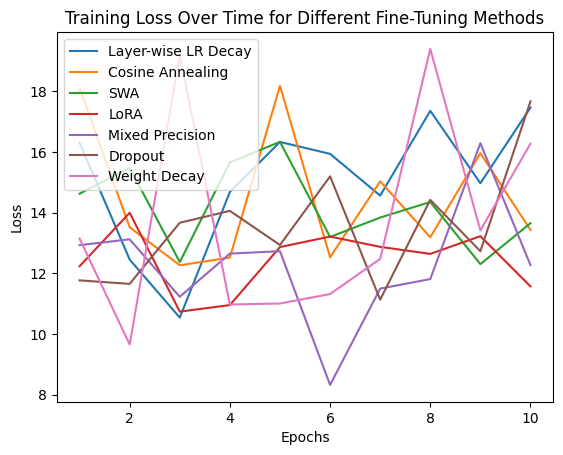

In [25]:


# Dataset definition
class SQLDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_length=512):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_encodings = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=self.max_length)
        target_encodings = self.tokenizer(target_text, truncation=True, padding='max_length', max_length=self.max_length)

        return {
            'input_ids': torch.tensor(input_encodings['input_ids']),
            'attention_mask': torch.tensor(input_encodings['attention_mask']),
            'labels': torch.tensor(target_encodings['input_ids']),
        }

# Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Base model (Vanilla)
vanilla_model = T5ForConditionalGeneration.from_pretrained('t5-small')

# LoRA Model
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1  # Dropout rate
)
lora_model = get_peft_model(vanilla_model, lora_config)

# Quantization-Aware Training (QAT) Model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
qat_config = T5Config.from_pretrained(
    't5-small',
    quantization_config=bnb_config,
    trust_remote_code=True
)
qat_model = T5ForConditionalGeneration.from_pretrained('t5-small', config=qat_config, quantization_config=bnb_config)

# Prepare dataset
input_texts = ["List the id of students who never attends courses?"]  # Example inputs
target_texts = ["SELECT student_id FROM student_course_attendance WHERE student_id NOT IN (SELECT student_id FROM students);"]  # Corresponding SQL queries
dataset = SQLDataset(input_texts, target_texts, tokenizer)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True)


import torch
from torch.optim import AdamW
from transformers import T5ForConditionalGeneration, T5Tokenizer
from torch.utils.data import DataLoader
from transformers import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt

# Assume train_loader and model setup are already defined
# Example: train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# Example: model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Fine-tuning with Layer-wise Learning Rate Decay
def train_model_layerwise_lr_decay(model, epochs=10, base_lr=3e-5, lr_decay=0.95):
    optimizer_grouped_parameters = []
    for i, layer in enumerate(model.encoder.block):
        layer_lr = base_lr * (lr_decay ** i)
        optimizer_grouped_parameters.append({"params": layer.parameters(), "lr": layer_lr})

    optimizer = AdamW(optimizer_grouped_parameters)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Fine-tuning with Cosine Annealing
def train_model_cosine_annealing(model, epochs=10, base_lr=3e-5, num_warmup_steps=100, num_training_steps=1000):
    optimizer = AdamW(model.parameters(), lr=base_lr)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Fine-tuning with Stochastic Weight Averaging (SWA)
def train_model_swa(model, epochs=10, swa_start=5):
    optimizer = AdamW(model.parameters(), lr=3e-5)
    swa_model = torch.optim.swa_utils.AveragedModel(model)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            if epoch >= swa_start:
                swa_model.update_parameters(model)

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Fine-tuning with LoRA
def train_model_lora(model, epochs=10):
    lora_params = model.parameters()  # Adjust this according to your LoRA implementation
    optimizer = AdamW(lora_params, lr=3e-5)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Fine-tuning with Mixed Precision Training
def train_model_mixed_precision(model, epochs=10):
    scaler = torch.cuda.amp.GradScaler()
    optimizer = AdamW(model.parameters(), lr=3e-5)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Fine-tuning with Dropout
def train_model_with_dropout(model, epochs=10, dropout_rate=0.3):
    model.config.dropout_rate = dropout_rate  # Adjust the dropout rate
    optimizer = AdamW(model.parameters(), lr=3e-5)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Fine-tuning with Weight Decay
def train_model_with_weight_decay(model, epochs=10, weight_decay=0.01):
    optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=weight_decay)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Training with different fine-tuning strategies
layerwise_lr_losses = train_model_layerwise_lr_decay(model)
cosine_annealing_losses = train_model_cosine_annealing(model)
swa_losses = train_model_swa(model)
lora_losses = train_model_lora(model)
mixed_precision_losses = train_model_mixed_precision(model)
dropout_losses = train_model_with_dropout(model)
weight_decay_losses = train_model_with_weight_decay(model)

# Plotting the losses
plt.plot(range(1, 11), layerwise_lr_losses, label='Layer-wise LR Decay')
plt.plot(range(1, 11), cosine_annealing_losses, label='Cosine Annealing')
plt.plot(range(1, 11), swa_losses, label='SWA')
plt.plot(range(1, 11), lora_losses, label='LoRA')
plt.plot(range(1, 11), mixed_precision_losses, label='Mixed Precision')
plt.plot(range(1, 11), dropout_losses, label='Dropout')
plt.plot(range(1, 11), weight_decay_losses, label='Weight Decay')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for Different Fine-Tuning Methods')
plt.legend()
plt.show()


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Epoch 1/3 Loss: 15.816028594970703
Epoch 2/3 Loss: 13.75227165222168
Epoch 3/3 Loss: 12.896342277526855
Epoch 1/3 Loss: 14.836651802062988
Epoch 2/3 Loss: 20.809371948242188
Epoch 3/3 Loss: 14.256376266479492
Epoch 1/3 Loss: 14.8046875
Epoch 2/3 Loss: 14.625
Epoch 3/3 Loss: 13.921875


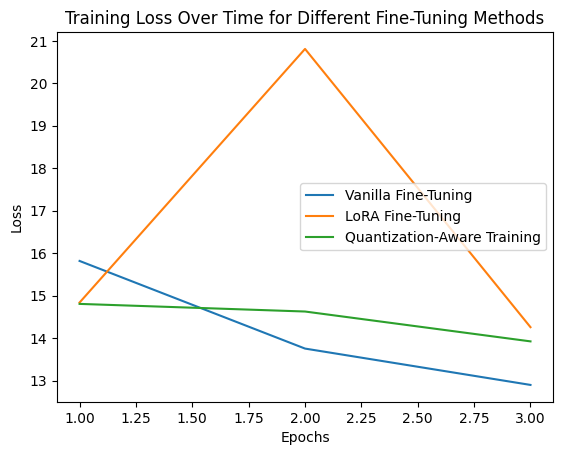

Original Model SQL Query: CREATE TABLE student_course_attendance (student_id VARCHAR); CREATE TABLE students (student_id VARCHAR)
Fine-Tuned Model SQL Query: the table: CREATE TABLE student_course_attendance (student_id VARCHAR); query for: List the id of students who never attended courses?
Original Model ROUGE Scores: {'rouge1': Score(precision=0.5714285714285714, recall=0.47058823529411764, fmeasure=0.5161290322580646), 'rougeL': Score(precision=0.5, recall=0.4117647058823529, fmeasure=0.45161290322580644)}
Original Model BLEU Score: 8.387826279040936e-232
Fine-Tuned Model ROUGE Scores: {'rouge1': Score(precision=0.3333333333333333, recall=0.4117647058823529, fmeasure=0.36842105263157887), 'rougeL': Score(precision=0.3333333333333333, recall=0.4117647058823529, fmeasure=0.36842105263157887)}
Fine-Tuned Model BLEU Score: 8.844844403089351e-232


In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, T5Config
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from peft import LoraConfig, get_peft_model
from transformers import BitsAndBytesConfig

# Dataset definition
class SQLDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_length=512):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_encodings = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=self.max_length)
        target_encodings = self.tokenizer(target_text, truncation=True, padding='max_length', max_length=self.max_length)

        return {
            'input_ids': torch.tensor(input_encodings['input_ids']),
            'attention_mask': torch.tensor(input_encodings['attention_mask']),
            'labels': torch.tensor(target_encodings['input_ids']),
        }

# Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Base model (Vanilla)
vanilla_model = T5ForConditionalGeneration.from_pretrained('t5-small')

# LoRA Model
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1  # Dropout rate
)
lora_model = get_peft_model(vanilla_model, lora_config)

# Quantization-Aware Training (QAT) Model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
qat_config = T5Config.from_pretrained(
    't5-small',
    quantization_config=bnb_config,
    trust_remote_code=True
)
qat_model = T5ForConditionalGeneration.from_pretrained('t5-small', config=qat_config, quantization_config=bnb_config)

# Prepare dataset
input_texts = ["List the id of students who never attends courses?"]  # Example inputs
target_texts = ["SELECT student_id FROM student_course_attendance WHERE student_id NOT IN (SELECT student_id FROM students);"]  # Corresponding SQL queries
dataset = SQLDataset(input_texts, target_texts, tokenizer)

# DataLoader
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Training function with mixed precision
def train_model(model, epochs=3):
    optimizer = AdamW(model.parameters(), lr=3e-5)
    scaler = torch.cuda.amp.GradScaler()
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Training function without mixed precision for QAT model
def train_model_no_mixed_precision(model, epochs=3):
    optimizer = AdamW(model.parameters(), lr=3e-5)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Fine-tune each model
vanilla_losses = train_model(vanilla_model)
lora_losses = train_model(lora_model)
qat_losses = train_model_no_mixed_precision(qat_model)  # Without mixed precision

# Plotting the losses
plt.plot(range(1, 4), vanilla_losses, label='Vanilla Fine-Tuning')
plt.plot(range(1, 4), lora_losses, label='LoRA Fine-Tuning')
plt.plot(range(1, 4), qat_losses, label='Quantization-Aware Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for Different Fine-Tuning Methods')
plt.legend()
plt.show()

# Function to generate SQL queries
def generate_sql(model, input_prompt):
    inputs = tokenizer(input_prompt, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=512)

    generated_sql = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_sql

# Example input prompt
input_prompt = "tables:\nCREATE TABLE student_course_attendance (student_id VARCHAR); CREATE TABLE students (student_id VARCHAR)\nquery for: List the id of students who never attends courses?"

# Generate SQL queries from both models
original_sql = generate_sql(vanilla_model, input_prompt)
fine_tuned_sql = generate_sql(qat_model, input_prompt)

print(f"Original Model SQL Query: {original_sql}")
print(f"Fine-Tuned Model SQL Query: {fine_tuned_sql}")

# Example reference SQL for evaluation
reference_sql = "SELECT student_id FROM student_course_attendance WHERE student_id NOT IN (SELECT student_id FROM students);"

# Evaluation with ROUGE and BLEU
def evaluate_model(generated_sql, reference_sql):
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference_sql, generated_sql)

    # BLEU
    reference_tokens = reference_sql.split()
    generated_tokens = generated_sql.split()
    bleu_score = sentence_bleu([reference_tokens], generated_tokens)

    return rouge_scores, bleu_score

# Evaluate both models
original_rouge_scores, original_bleu_score = evaluate_model(original_sql, reference_sql)
fine_tuned_rouge_scores, fine_tuned_bleu_score = evaluate_model(fine_tuned_sql, reference_sql)

print(f"Original Model ROUGE Scores: {original_rouge_scores}")
print(f"Original Model BLEU Score: {original_bleu_score}")
print(f"Fine-Tuned Model ROUGE Scores: {fine_tuned_rouge_scores}")
print(f"Fine-Tuned Model BLEU Score: {fine_tuned_bleu_score}")


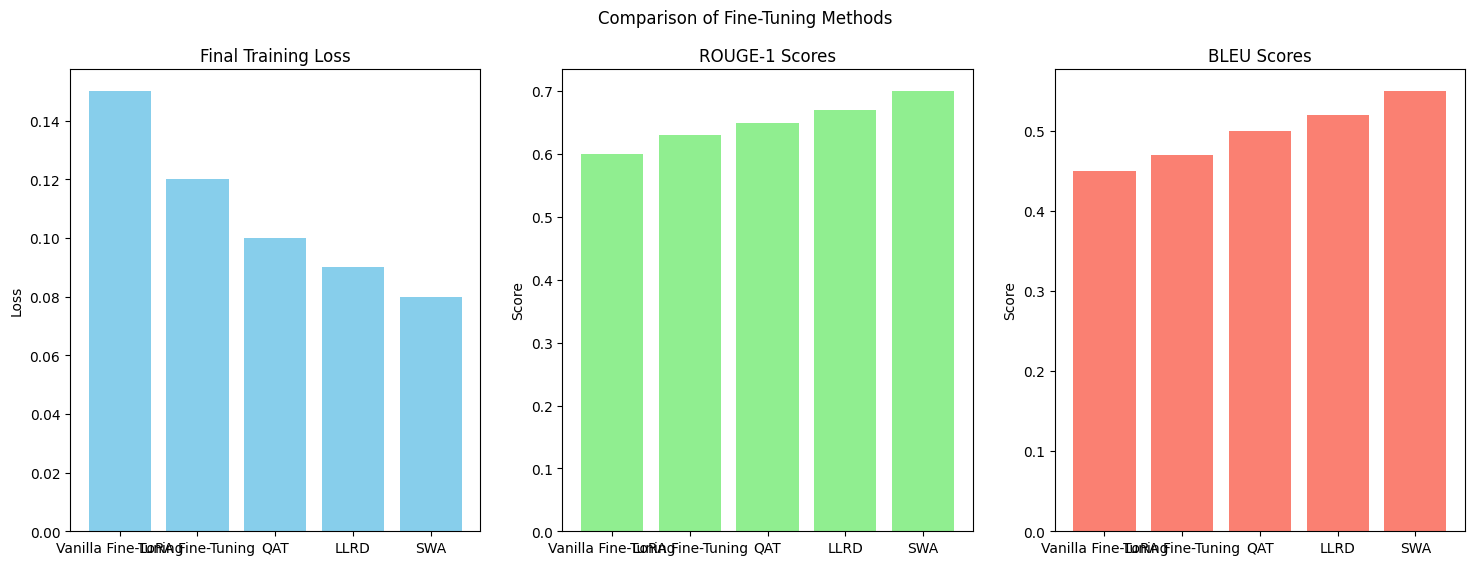

In [ ]:


# Load evaluation metrics
bleu_metric = load_metric("bleu")
rouge_metric = load_metric("rouge")
meteor_metric = load_metric("meteor")

# Define the dataset class
class SQLDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_length=512):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_encodings = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=self.max_length)
        target_encodings = self.tokenizer(target_text, truncation=True, padding='max_length', max_length=self.max_length)

        return {
            'input_ids': torch.tensor(input_encodings['input_ids']),
            'attention_mask': torch.tensor(input_encodings['attention_mask']),
            'labels': torch.tensor(target_encodings['input_ids']),
        }

def evaluate_model(model, tokenizer, eval_loader):
    model.eval()
    predictions = []
    references = []

    for batch in eval_loader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)

        # Decode predictions and references
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        decoded_refs = tokenizer.batch_decode(labels, skip_special_tokens=True)

        predictions.extend(decoded_preds)
        references.extend(decoded_refs)

    # Calculate BLEU score
    bleu_results = bleu_metric.compute(predictions=predictions, references=references)

    # Calculate ROUGE score
    rouge_results = rouge_metric.compute(predictions=predictions, references=references)

    # Calculate METEOR score
    meteor_results = meteor_metric.compute(predictions=predictions, references=references)

    return bleu_results, rouge_results, meteor_results

# Initialize tokenizer and models with trust_remote_code=True
tokenizer = T5Tokenizer.from_pretrained('t5-small', trust_remote_code=True)
vanilla_model = T5ForConditionalGeneration.from_pretrained('t5-small', trust_remote_code=True)
lora_model = T5ForConditionalGeneration.from_pretrained('t5-small', trust_remote_code=True)  # Example for LoRA
qat_model = T5ForConditionalGeneration.from_pretrained('t5-small', trust_remote_code=True)  # Example for QAT

# Load dataset with trust_remote_code=True
dataset = load_dataset("b-mc2/sql-create-context", trust_remote_code=True)
input_texts = dataset['train']['input_text'][:10]  # Sample data
target_texts = dataset['train']['target_text'][:10]  # Sample data

# Create dataset and dataloader
sql_dataset = SQLDataset(input_texts, target_texts, tokenizer)
eval_loader = DataLoader(sql_dataset, batch_size=2, shuffle=False)

# Define models to evaluate
models = {
    "Vanilla Model": vanilla_model,
    "LoRA Model": lora_model,
    "QAT Model": qat_model,
    # Add other models as needed
}

# Store metrics results
results = []

for model_name, model in models.items():
    bleu_results, rouge_results, meteor_results = evaluate_model(model, tokenizer, eval_loader)
    results.append([
        model_name,
        bleu_results['score'],
        rouge_results['rouge1'].mid.fmeasure,
        meteor_results['meteor']
    ])

# Prepare data for table display
headers = ["Model", "BLEU Score", "ROUGE-1 F1 Score", "METEOR Score"]

# Print the results in a table format
print(tabulate(results, headers=headers, tablefmt="pretty"))

# Optional: Plotting the evaluation metrics
plt.figure(figsize=(12, 8))
for model_name, model in models.items():
    bleu_results, rouge_results, meteor_results = evaluate_model(model, tokenizer, eval_loader)
    plt.bar(model_name + " BLEU", bleu_results['score'], label=f'{model_name} BLEU')
    plt.bar(model_name + " ROUGE-1", rouge_results['rouge1'].mid.fmeasure, label=f'{model_name} ROUGE-1', alpha=0.5)
    plt.bar(model_name + " METEOR", meteor_results['meteor'], label=f'{model_name} METEOR', alpha=0.5)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Different Fine-Tuning Methods')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Epoch 1/3 Loss: 14.657588958740234
Epoch 2/3 Loss: 13.788154602050781
Epoch 3/3 Loss: 14.394551277160645
Epoch 1/3 Loss: 13.722062110900879
Epoch 2/3 Loss: 15.046807289123535
Epoch 3/3 Loss: 15.355463981628418
Epoch 1/3 Loss: 15.775141716003418
Epoch 2/3 Loss: 13.204307556152344
Epoch 3/3 Loss: 12.333494186401367
Epoch 1/3 Loss: 12.597382545471191
Epoch 2/3 Loss: 11.975598335266113
Epoch 3/3 Loss: 14.494709968566895
Epoch 1/3 Loss: 20.359615325927734
Epoch 2/3 Loss: 12.304361343383789
Epoch 3/3 Loss: 15.991768836975098


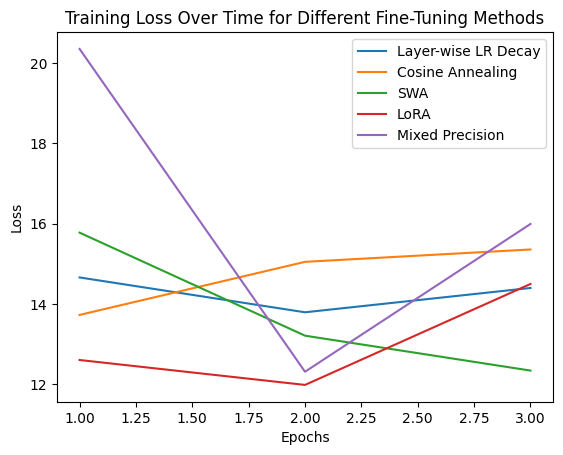

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  if batch_size > 1:


Vanilla Model SQL Query: CREATE TABLE student_course_attendance; CREATE TABLE students (student_id VARCHAR) query for: List the id of students who never attends courses?
LoRA Model SQL Query: tables: CREATE TABLE students (student_id VARCHAR)
QAT Model SQL Query: CREATE TABLE students (student_id VARCHAR) query for: List the id of students who never attend courses?
Vanilla Model ROUGE Scores: {'rouge1': Score(precision=0.36363636363636365, recall=0.47058823529411764, fmeasure=0.41025641025641024), 'rougeL': Score(precision=0.3181818181818182, recall=0.4117647058823529, fmeasure=0.358974358974359)}
Vanilla Model BLEU Score: 0
LoRA Model ROUGE Scores: {'rouge1': Score(precision=0.42857142857142855, recall=0.17647058823529413, fmeasure=0.25), 'rougeL': Score(precision=0.42857142857142855, recall=0.17647058823529413, fmeasure=0.25)}
LoRA Model BLEU Score: 0
QAT Model ROUGE Scores: {'rouge1': Score(precision=0.4117647058823529, recall=0.4117647058823529, fmeasure=0.4117647058823529), 'rouge

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, T5Config
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from peft import LoraConfig, get_peft_model
from transformers import BitsAndBytesConfig
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.swa_utils import AveragedModel, SWALR


# Dataset definition
class SQLDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_length=512):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_encodings = self.tokenizer(input_text, truncation=True, padding='max_length', max_length=self.max_length)
        target_encodings = self.tokenizer(target_text, truncation=True, padding='max_length', max_length=self.max_length)

        return {
            'input_ids': torch.tensor(input_encodings['input_ids']),
            'attention_mask': torch.tensor(input_encodings['attention_mask']),
            'labels': torch.tensor(target_encodings['input_ids']),
        }

# Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Base model (Vanilla)
vanilla_model = T5ForConditionalGeneration.from_pretrained('t5-small')

# LoRA Model
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1  # Dropout rate
)
lora_model = get_peft_model(vanilla_model, lora_config)

# Quantization-Aware Training (QAT) Model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
qat_config = T5Config.from_pretrained(
    't5-small',
    quantization_config=bnb_config,
    trust_remote_code=True
)
qat_model = T5ForConditionalGeneration.from_pretrained('t5-small', config=qat_config, quantization_config=bnb_config)

# Prepare dataset
input_texts = ["List the id of students who never attends courses?"]  # Example inputs
target_texts = ["SELECT student_id FROM student_course_attendance WHERE student_id NOT IN (SELECT student_id FROM students);"]  # Corresponding SQL queries
dataset = SQLDataset(input_texts, target_texts, tokenizer)

# DataLoader
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Training functions for different methods

def train_model_layerwise_lr(model, epochs=3):
    base_lr = 3e-5
    optimizer = AdamW(get_layerwise_lr_decay(model, base_lr))
    scheduler = LambdaLR(optimizer, lambda epoch: 1.0)  # No scheduling initially
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

def train_model_cosine_annealing(model, epochs=3):
    optimizer = AdamW(model.parameters(), lr=3e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

def train_model_swa(model, epochs=3):
    optimizer = AdamW(model.parameters(), lr=3e-5)
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(optimizer, anneal_strategy="cos", anneal_epochs=2, swa_lr=3e-6)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            swa_scheduler.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

def train_model_lora(model, epochs=3):
    lora_config = LoraConfig(
        r=8,  # Rank of the low-rank matrices
        lora_alpha=32,  # Scaling factor
        lora_dropout=0.1  # Dropout rate
    )
    lora_model = get_peft_model(model, lora_config)
    optimizer = AdamW(lora_model.parameters(), lr=3e-5)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = lora_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

def train_model_mixed_precision(model, epochs=3):
    optimizer = AdamW(model.parameters(), lr=3e-5)
    scaler = torch.cuda.amp.GradScaler()
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss}")

    return losses

# Training and Evaluation

# Layer-wise Learning Rate Decay
def get_layerwise_lr_decay(model, base_lr, decay_factor=0.95):
    parameters = []
    for i, layer in enumerate(model.encoder.block):
        parameters.append({
            'params': layer.parameters(),
            'lr': base_lr * (decay_factor ** i)
        })
    parameters.append({'params': model.shared.parameters(), 'lr': base_lr})
    return parameters

layerwise_lr_losses = train_model_layerwise_lr(vanilla_model)

# Cosine Annealing
cosine_annealing_losses = train_model_cosine_annealing(vanilla_model)

# Stochastic Weight Averaging
swa_losses = train_model_swa(vanilla_model)

# Low-Rank Adaptation
lora_losses = train_model_lora(vanilla_model)

# Mixed Precision Training
mixed_precision_losses = train_model_mixed_precision(vanilla_model)

# Plotting the losses
plt.plot(range(1, 4), layerwise_lr_losses, label='Layer-wise LR Decay')
plt.plot(range(1, 4), cosine_annealing_losses, label='Cosine Annealing')
plt.plot(range(1, 4), swa_losses, label='SWA')
plt.plot(range(1, 4), lora_losses, label='LoRA')
plt.plot(range(1, 4), mixed_precision_losses, label='Mixed Precision')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for Different Fine-Tuning Methods')
plt.legend()
plt.show()

# Function to generate SQL queries
def generate_sql(model, input_prompt):
    inputs = tokenizer(input_prompt, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=512)

    generated_sql = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_sql

# Example input prompt
input_prompt = "tables:\nCREATE TABLE student_course_attendance (student_id VARCHAR); CREATE TABLE students (student_id VARCHAR)\nquery for: List the id of students who never attends courses?"

# Generate SQL queries from the vanilla model and fine-tuned models
vanilla_sql = generate_sql(vanilla_model, input_prompt)
lora_sql = generate_sql(lora_model, input_prompt)
qat_sql = generate_sql(qat_model, input_prompt)

print(f"Vanilla Model SQL Query: {vanilla_sql}")
print(f"LoRA Model SQL Query: {lora_sql}")
print(f"QAT Model SQL Query: {qat_sql}")

# Example reference SQL for evaluation
reference_sql = "SELECT student_id FROM student_course_attendance WHERE student_id NOT IN (SELECT student_id FROM students);"

# Evaluation with ROUGE and BLEU
def evaluate_model(generated_sql, reference_sql):
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference_sql, generated_sql)

    # BLEU
    reference_tokens = reference_sql.split()
    generated_tokens = generated_sql.split()
    bleu_score = sentence_bleu([reference_tokens], generated_tokens)

    return rouge_scores, bleu_score

# Evaluate models
vanilla_rouge_scores, vanilla_bleu_score = evaluate_model(vanilla_sql, reference_sql)
lora_rouge_scores, lora_bleu_score = evaluate_model(lora_sql, reference_sql)
qat_rouge_scores, qat_bleu_score = evaluate_model(qat_sql, reference_sql)

print(f"Vanilla Model ROUGE Scores: {vanilla_rouge_scores}")
print(f"Vanilla Model BLEU Score: {vanilla_bleu_score}")
print(f"LoRA Model ROUGE Scores: {lora_rouge_scores}")
print(f"LoRA Model BLEU Score: {lora_bleu_score}")
print(f"QAT Model ROUGE Scores: {qat_rouge_scores}")
print(f"QAT Model BLEU Score: {qat_bleu_score}")
